In [1]:
#Importing dependencies
import csv
import cv2
import h5py
import itertools
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import random
import scipy
import seaborn as sns
import sklearn
import skimage
import warnings
import zlib

from glob import glob
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import backend as K
from keras import models, layers, optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Lambda, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.utils import class_weight
from tqdm import tqdm
from PIL import Image

%matplotlib inline
warnings.filterwarnings("ignore")

C:\Users\Marcos\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Variables
#Directories
dir_dataset = "../DataSet/"
dir_dataset_train = dir_dataset + "train/"
dir_dataset_test  = dir_dataset + "test/"
dir_transferlearning = "../TransferLearning/"

#Labels
normal_label    = 0
pneumonia_label = 1
unknown_label   = 2

#Dataset
name_dataset = "dataset.h5"
exists_dataset = True

#Directories Transfer learning
pretrained_label_VGG16 = 'VGG16'
pretrained_label_InceptionV3 = 'InceptionV3'

dir_transferlearning_vgg16 = dir_transferlearning +  "Vgg16.h5"
dir_transferlearning_inception = dir_transferlearning +  "InceptionV3.h5"

In [3]:
#Defining hyperparameters
height_img          = 150
width_img           = 150
channel_img         = 3
max_epoch_vgg16     = 30
max_epoch_inception = 100
number_classes      = 2
optimizer           = keras.optimizers.RMSprop(lr=0.0001)

In [4]:
#Defining map characters and transferLearning
map_characters = {normal_label: 'No Pneumonia',
                  pneumonia_label: 'Yes Pneumonia'}

pretrained_model_VGG16 = VGG16(weights = dir_transferlearning_vgg16,
                               include_top=False,
                               input_shape=(height_img, width_img, channel_img))

pretrained_model_InceptionV3 = InceptionV3(weights = dir_transferlearning_inception,
                                           include_top=False,
                                           input_shape=(height_img, width_img, channel_img))

In [5]:
#Load and define mehotd resizing load image
def get_dataset_resizing(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            
            if folderName in ['NORMAL']:
                label = normal_label
            elif folderName in ['PNEUMONIA']:
                label = pneumonia_label
            else:
                label = unknown_label
                
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (height_img, width_img, channel_img))                
                    img_arr = np.asarray(img_file)
                    x.append(img_arr)
                    y.append(label)
                    
    x = np.asarray(x)
    y = np.asarray(y)
    
    return x,y

In [6]:
#create memory dataset
if not exists_dataset:
    x_train, y_train = get_dataset_resizing(dir_dataset_train)
    x_test,  y_test  = get_dataset_resizing(dir_dataset_test)

In [7]:
#save dataset in computer or load dataset from computer
if not exists_dataset:
    hf = h5py.File(name_dataset, 'w')
    hf.create_dataset('x_train', data=x_train)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('x_test', data=x_test)
    hf.create_dataset('y_test', data=y_test)
    hf.close()
else:
    with h5py.File(name_dataset,'r') as hf:
        x_train = hf['x_train'][:]
        y_train = hf['y_train'][:]
        x_test  = hf['x_test'][:]
        y_test  = hf['y_test'][:]

In [8]:
#converts the dataset to binary array
y_train_hot = to_categorical(y_train, num_classes = number_classes)
y_test_hot  = to_categorical(y_test, num_classes = number_classes)

In [9]:
#defining metric and presentation of the obtained results
class MetricsCheckpoint(Callback):    
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc']
    
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.10f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
        
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.savefig('./loss_curve.png')

In [10]:
#Defining network architecture
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, i_pretrained_model, pretrained_label,
                      i_pretrained_weights, i_class_weight, i_num_classes,
                      i_max_epochs, i_optimizer, i_labels):
    
    if pretrained_label in pretrained_label_VGG16:
        base_model  = pretrained_model_VGG16
    elif pretrained_label in pretrained_label_InceptionV3:        
        base_model  = pretrained_model_InceptionV3    
    else:
        base_model  = pretrained_model_VGG16       
        
    x           = base_model.output
    x           = Flatten()(x)
    predictions = Dense(i_num_classes, activation='softmax')(x)
    model       = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False        
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=i_optimizer, 
                  metrics=['accuracy'])
    
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    history = model.fit(xtrain, ytrain, epochs=i_max_epochs, class_weight=i_class_weight,
                        validation_data=(xtest, ytest), verbose=1,
                        callbacks = [MetricsCheckpoint('logs')])
    
    model.save_weights('DeepLearningPneumonia.h5')
    
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1],
                                                      np.argmax(y_pred, axis=1),
                                                      target_names=list(i_labels.values())), sep='') 
    
    Y_pred_classes = np.argmax(y_pred, axis = 1) 
    Y_true = np.argmax(ytest, axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(i_labels.values()))
    plt.show()
    return model    

In [11]:
#Initial weights
x_train_shape = x_train.shape[1]*x_train.shape[2]*x_train.shape[3]
x_test_shape  = x_test.shape[1]*x_test.shape[2]*x_test.shape[3]
x_train_flat  = x_train.reshape(x_train.shape[0], x_train_shape)
x_test_flat   = x_test.reshape(x_test.shape[0], x_test_shape)

yy_train = y_train
yy_test  = y_test
ros      = RandomUnderSampler(ratio='auto')

x_train_ros, y_train_ros = ros.fit_sample(x_train_flat, yy_train)
x_test_ros, y_test_ros   = ros.fit_sample(x_test_flat, yy_test)

y_train_ros_hot = to_categorical(y_train_ros, num_classes = number_classes)
y_test_ros_hot = to_categorical(y_test_ros, num_classes = number_classes)

for i in range(len(x_train_ros)):
    height, width, channels = height_img, width_img, channel_img
    x_train_ros_reshaped = x_train_ros.reshape(len(x_train_ros), height, width, channels)
    
for i in range(len(x_test_ros)):
    height, width, channels = height_img, width_img, channel_img
    x_test_ros_reshaped = x_test_ros.reshape(len(x_test_ros), height,width, channels)

In [12]:
#Weight balancing
class_weight_y = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print("Class Weights: ", class_weight_y)

class_weight_yy = class_weight.compute_class_weight('balanced', np.unique(yy_train), yy_train)
print("Old Class Weights: ", class_weight_yy)

class_weight_ros = class_weight.compute_class_weight('balanced', np.unique(y_train_ros), y_train_ros)
print("New Class Weights: ", class_weight_ros)

Class Weights:  [1.93921423 0.6737059 ]
Old Class Weights:  [1.93921423 0.6737059 ]
New Class Weights:  [1. 1.]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

5396/5396 [==============================] - ETA: 15:23 - loss: 0.9943 - acc: 0.53 - ETA: 7:44 - loss: 0.8211 - acc: 0.5938 - ETA: 5:10 - loss: 0.8218 - acc: 0.552 - ETA: 3:54 - loss: 0.8235 - acc: 0.507 - ETA: 3:08 - loss: 0.7922 - acc: 0.512 - ETA: 2:37 - loss: 0.7681 - acc: 0.546 - ETA: 2:15 - loss: 0.7442 - acc: 0.580 - ETA: 1:58 - loss: 0.7224 - acc: 0.613 - ETA: 1:46 - loss: 0.7079 - acc: 0.631 - ETA: 1:35 - loss: 0.6932 - acc: 0.665 - ETA: 1:27 - loss: 0.6789 - acc: 0.690 - ETA: 1:20 - loss: 0.6703 - acc: 0.695 - ETA: 1:14 - loss: 0.6621 - acc: 0.704 - ETA: 1:09 - loss: 0.6539 - acc: 0.716 - ETA: 1:04 - loss: 0.6437 - acc: 0.729 - ETA: 1:00 - loss: 0.6376 - acc: 0.734 - ETA: 57s - loss: 0.6341 - acc: 0.733 - ETA: 54s - loss: 0.6255 - acc: 0.74 - ETA: 51s - loss: 0.6186 - acc: 0.75 - ETA: 49s - loss: 0.6131 - acc: 0.75 - ETA: 47s - loss: 0.6084 - acc: 0.76 - ETA: 44s - loss: 0.6020 - acc: 0.77 - ETA: 43s - loss: 0.5986 - acc: 0.77 - ETA: 41s - loss: 0.5936 - acc: 0.77 - ETA: 39s 

5396/5396 [==============================] - ETA: 9s - loss: 0.2197 - acc: 0.937 - ETA: 9s - loss: 0.1655 - acc: 0.968 - ETA: 9s - loss: 0.1646 - acc: 0.979 - ETA: 9s - loss: 0.1744 - acc: 0.984 - ETA: 9s - loss: 0.1846 - acc: 0.968 - ETA: 9s - loss: 0.1896 - acc: 0.958 - ETA: 9s - loss: 0.1934 - acc: 0.950 - ETA: 9s - loss: 0.2006 - acc: 0.949 - ETA: 9s - loss: 0.2083 - acc: 0.944 - ETA: 9s - loss: 0.2196 - acc: 0.937 - ETA: 9s - loss: 0.2187 - acc: 0.937 - ETA: 9s - loss: 0.2129 - acc: 0.940 - ETA: 8s - loss: 0.2076 - acc: 0.944 - ETA: 8s - loss: 0.2091 - acc: 0.946 - ETA: 8s - loss: 0.2077 - acc: 0.945 - ETA: 8s - loss: 0.2094 - acc: 0.941 - ETA: 8s - loss: 0.2122 - acc: 0.939 - ETA: 8s - loss: 0.2115 - acc: 0.939 - ETA: 8s - loss: 0.2150 - acc: 0.934 - ETA: 8s - loss: 0.2131 - acc: 0.937 - ETA: 8s - loss: 0.2137 - acc: 0.936 - ETA: 8s - loss: 0.2142 - acc: 0.936 - ETA: 8s - loss: 0.2119 - acc: 0.937 - ETA: 8s - loss: 0.2159 - acc: 0.934 - ETA: 8s - loss: 0.2155 - acc: 0.936 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.2545 - acc: 0.843 - ETA: 9s - loss: 0.1698 - acc: 0.921 - ETA: 9s - loss: 0.1648 - acc: 0.927 - ETA: 9s - loss: 0.1703 - acc: 0.921 - ETA: 9s - loss: 0.1505 - acc: 0.931 - ETA: 9s - loss: 0.1462 - acc: 0.932 - ETA: 9s - loss: 0.1573 - acc: 0.928 - ETA: 9s - loss: 0.1521 - acc: 0.933 - ETA: 9s - loss: 0.1537 - acc: 0.934 - ETA: 9s - loss: 0.1627 - acc: 0.928 - ETA: 9s - loss: 0.1592 - acc: 0.931 - ETA: 8s - loss: 0.1566 - acc: 0.934 - ETA: 8s - loss: 0.1580 - acc: 0.935 - ETA: 8s - loss: 0.1580 - acc: 0.937 - ETA: 8s - loss: 0.1531 - acc: 0.941 - ETA: 8s - loss: 0.1498 - acc: 0.943 - ETA: 8s - loss: 0.1475 - acc: 0.944 - ETA: 8s - loss: 0.1478 - acc: 0.942 - ETA: 8s - loss: 0.1453 - acc: 0.944 - ETA: 8s - loss: 0.1471 - acc: 0.942 - ETA: 8s - loss: 0.1466 - acc: 0.940 - ETA: 8s - loss: 0.1466 - acc: 0.940 - ETA: 8s - loss: 0.1519 - acc: 0.938 - ETA: 8s - loss: 0.1508 - acc: 0.938 - ETA: 8s - loss: 0.1519 - acc: 0.937 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0471 - acc: 1.000 - ETA: 9s - loss: 0.0710 - acc: 0.984 - ETA: 9s - loss: 0.1181 - acc: 0.968 - ETA: 9s - loss: 0.1299 - acc: 0.968 - ETA: 9s - loss: 0.1499 - acc: 0.956 - ETA: 9s - loss: 0.1464 - acc: 0.953 - ETA: 9s - loss: 0.1574 - acc: 0.950 - ETA: 9s - loss: 0.1471 - acc: 0.953 - ETA: 9s - loss: 0.1592 - acc: 0.941 - ETA: 9s - loss: 0.1559 - acc: 0.943 - ETA: 9s - loss: 0.1586 - acc: 0.943 - ETA: 8s - loss: 0.1543 - acc: 0.945 - ETA: 8s - loss: 0.1498 - acc: 0.944 - ETA: 8s - loss: 0.1486 - acc: 0.944 - ETA: 8s - loss: 0.1444 - acc: 0.945 - ETA: 8s - loss: 0.1415 - acc: 0.949 - ETA: 8s - loss: 0.1413 - acc: 0.950 - ETA: 8s - loss: 0.1365 - acc: 0.953 - ETA: 8s - loss: 0.1347 - acc: 0.952 - ETA: 8s - loss: 0.1338 - acc: 0.953 - ETA: 8s - loss: 0.1327 - acc: 0.953 - ETA: 8s - loss: 0.1356 - acc: 0.953 - ETA: 8s - loss: 0.1366 - acc: 0.952 - ETA: 8s - loss: 0.1395 - acc: 0.949 - ETA: 8s - loss: 0.1368 - acc: 0.951 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0947 - acc: 0.968 - ETA: 9s - loss: 0.0625 - acc: 0.984 - ETA: 9s - loss: 0.1032 - acc: 0.958 - ETA: 9s - loss: 0.1028 - acc: 0.968 - ETA: 9s - loss: 0.1008 - acc: 0.962 - ETA: 9s - loss: 0.0983 - acc: 0.963 - ETA: 9s - loss: 0.1043 - acc: 0.959 - ETA: 9s - loss: 0.1069 - acc: 0.960 - ETA: 9s - loss: 0.1109 - acc: 0.961 - ETA: 9s - loss: 0.1179 - acc: 0.956 - ETA: 9s - loss: 0.1239 - acc: 0.954 - ETA: 9s - loss: 0.1212 - acc: 0.955 - ETA: 8s - loss: 0.1173 - acc: 0.956 - ETA: 8s - loss: 0.1181 - acc: 0.957 - ETA: 8s - loss: 0.1191 - acc: 0.956 - ETA: 8s - loss: 0.1159 - acc: 0.959 - ETA: 8s - loss: 0.1154 - acc: 0.957 - ETA: 8s - loss: 0.1139 - acc: 0.958 - ETA: 8s - loss: 0.1130 - acc: 0.958 - ETA: 8s - loss: 0.1138 - acc: 0.957 - ETA: 8s - loss: 0.1128 - acc: 0.958 - ETA: 8s - loss: 0.1141 - acc: 0.957 - ETA: 8s - loss: 0.1148 - acc: 0.956 - ETA: 8s - loss: 0.1231 - acc: 0.954 - ETA: 8s - loss: 0.1211 - acc: 0.955 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0702 - acc: 0.968 - ETA: 9s - loss: 0.0715 - acc: 0.968 - ETA: 9s - loss: 0.1056 - acc: 0.958 - ETA: 9s - loss: 0.1068 - acc: 0.960 - ETA: 9s - loss: 0.1008 - acc: 0.962 - ETA: 9s - loss: 0.1004 - acc: 0.963 - ETA: 9s - loss: 0.1133 - acc: 0.964 - ETA: 9s - loss: 0.1164 - acc: 0.960 - ETA: 9s - loss: 0.1087 - acc: 0.965 - ETA: 9s - loss: 0.1023 - acc: 0.968 - ETA: 9s - loss: 0.1042 - acc: 0.968 - ETA: 8s - loss: 0.1020 - acc: 0.971 - ETA: 8s - loss: 0.1100 - acc: 0.968 - ETA: 8s - loss: 0.1056 - acc: 0.971 - ETA: 8s - loss: 0.1047 - acc: 0.970 - ETA: 8s - loss: 0.1012 - acc: 0.972 - ETA: 8s - loss: 0.0991 - acc: 0.972 - ETA: 8s - loss: 0.0963 - acc: 0.974 - ETA: 8s - loss: 0.0994 - acc: 0.972 - ETA: 8s - loss: 0.0984 - acc: 0.973 - ETA: 8s - loss: 0.1013 - acc: 0.971 - ETA: 8s - loss: 0.1012 - acc: 0.971 - ETA: 8s - loss: 0.0992 - acc: 0.971 - ETA: 8s - loss: 0.1034 - acc: 0.970 - ETA: 8s - loss: 0.1029 - acc: 0.970 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0390 - acc: 1.000 - ETA: 9s - loss: 0.0501 - acc: 1.000 - ETA: 9s - loss: 0.0566 - acc: 0.989 - ETA: 9s - loss: 0.0651 - acc: 0.984 - ETA: 9s - loss: 0.0821 - acc: 0.975 - ETA: 9s - loss: 0.0755 - acc: 0.979 - ETA: 9s - loss: 0.0807 - acc: 0.977 - ETA: 9s - loss: 0.0770 - acc: 0.980 - ETA: 9s - loss: 0.0788 - acc: 0.979 - ETA: 9s - loss: 0.0889 - acc: 0.975 - ETA: 9s - loss: 0.0875 - acc: 0.977 - ETA: 9s - loss: 0.0931 - acc: 0.974 - ETA: 9s - loss: 0.0901 - acc: 0.976 - ETA: 8s - loss: 0.0948 - acc: 0.975 - ETA: 8s - loss: 0.0949 - acc: 0.975 - ETA: 8s - loss: 0.0931 - acc: 0.974 - ETA: 8s - loss: 0.0924 - acc: 0.976 - ETA: 8s - loss: 0.0884 - acc: 0.977 - ETA: 8s - loss: 0.0879 - acc: 0.975 - ETA: 8s - loss: 0.0868 - acc: 0.975 - ETA: 8s - loss: 0.0850 - acc: 0.976 - ETA: 8s - loss: 0.0841 - acc: 0.977 - ETA: 8s - loss: 0.0825 - acc: 0.978 - ETA: 8s - loss: 0.0801 - acc: 0.979 - ETA: 8s - loss: 0.0811 - acc: 0.978 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.1399 - acc: 0.968 - ETA: 9s - loss: 0.1076 - acc: 0.968 - ETA: 9s - loss: 0.1103 - acc: 0.958 - ETA: 9s - loss: 0.1101 - acc: 0.953 - ETA: 9s - loss: 0.0998 - acc: 0.956 - ETA: 9s - loss: 0.1016 - acc: 0.953 - ETA: 9s - loss: 0.1088 - acc: 0.946 - ETA: 9s - loss: 0.1023 - acc: 0.949 - ETA: 9s - loss: 0.1026 - acc: 0.947 - ETA: 9s - loss: 0.0993 - acc: 0.953 - ETA: 9s - loss: 0.0982 - acc: 0.954 - ETA: 8s - loss: 0.0998 - acc: 0.955 - ETA: 8s - loss: 0.0956 - acc: 0.959 - ETA: 8s - loss: 0.0913 - acc: 0.962 - ETA: 8s - loss: 0.0906 - acc: 0.964 - ETA: 8s - loss: 0.0889 - acc: 0.964 - ETA: 8s - loss: 0.0892 - acc: 0.965 - ETA: 8s - loss: 0.0902 - acc: 0.965 - ETA: 8s - loss: 0.0889 - acc: 0.965 - ETA: 8s - loss: 0.0857 - acc: 0.967 - ETA: 8s - loss: 0.0862 - acc: 0.967 - ETA: 8s - loss: 0.0912 - acc: 0.963 - ETA: 8s - loss: 0.0954 - acc: 0.963 - ETA: 8s - loss: 0.0963 - acc: 0.963 - ETA: 8s - loss: 0.0937 - acc: 0.965 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0617 - acc: 1.000 - ETA: 9s - loss: 0.0863 - acc: 0.968 - ETA: 9s - loss: 0.0968 - acc: 0.958 - ETA: 9s - loss: 0.0860 - acc: 0.968 - ETA: 9s - loss: 0.0804 - acc: 0.975 - ETA: 9s - loss: 0.0766 - acc: 0.974 - ETA: 9s - loss: 0.0744 - acc: 0.977 - ETA: 9s - loss: 0.0729 - acc: 0.980 - ETA: 9s - loss: 0.0753 - acc: 0.979 - ETA: 9s - loss: 0.0746 - acc: 0.981 - ETA: 9s - loss: 0.0731 - acc: 0.983 - ETA: 8s - loss: 0.0728 - acc: 0.981 - ETA: 8s - loss: 0.0745 - acc: 0.978 - ETA: 8s - loss: 0.0749 - acc: 0.977 - ETA: 8s - loss: 0.0838 - acc: 0.972 - ETA: 8s - loss: 0.0899 - acc: 0.970 - ETA: 8s - loss: 0.0879 - acc: 0.970 - ETA: 8s - loss: 0.0884 - acc: 0.970 - ETA: 8s - loss: 0.0856 - acc: 0.972 - ETA: 8s - loss: 0.0912 - acc: 0.967 - ETA: 8s - loss: 0.0959 - acc: 0.967 - ETA: 8s - loss: 0.0944 - acc: 0.968 - ETA: 8s - loss: 0.0953 - acc: 0.967 - ETA: 8s - loss: 0.0933 - acc: 0.968 - ETA: 8s - loss: 0.0919 - acc: 0.968 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0525 - acc: 1.000 - ETA: 9s - loss: 0.0702 - acc: 0.984 - ETA: 9s - loss: 0.0710 - acc: 0.968 - ETA: 9s - loss: 0.0683 - acc: 0.968 - ETA: 9s - loss: 0.0692 - acc: 0.968 - ETA: 9s - loss: 0.0639 - acc: 0.974 - ETA: 9s - loss: 0.0653 - acc: 0.977 - ETA: 9s - loss: 0.0628 - acc: 0.980 - ETA: 9s - loss: 0.0613 - acc: 0.979 - ETA: 9s - loss: 0.0676 - acc: 0.978 - ETA: 9s - loss: 0.0684 - acc: 0.977 - ETA: 8s - loss: 0.0732 - acc: 0.976 - ETA: 8s - loss: 0.0693 - acc: 0.978 - ETA: 8s - loss: 0.0679 - acc: 0.977 - ETA: 8s - loss: 0.0662 - acc: 0.979 - ETA: 8s - loss: 0.0700 - acc: 0.976 - ETA: 8s - loss: 0.0702 - acc: 0.976 - ETA: 8s - loss: 0.0689 - acc: 0.977 - ETA: 8s - loss: 0.0713 - acc: 0.975 - ETA: 8s - loss: 0.0699 - acc: 0.976 - ETA: 8s - loss: 0.0696 - acc: 0.977 - ETA: 8s - loss: 0.0701 - acc: 0.977 - ETA: 8s - loss: 0.0720 - acc: 0.975 - ETA: 8s - loss: 0.0716 - acc: 0.975 - ETA: 8s - loss: 0.0722 - acc: 0.975 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0196 - acc: 1.000 - ETA: 9s - loss: 0.0349 - acc: 1.000 - ETA: 9s - loss: 0.0350 - acc: 1.000 - ETA: 9s - loss: 0.0506 - acc: 0.984 - ETA: 9s - loss: 0.0665 - acc: 0.981 - ETA: 9s - loss: 0.0678 - acc: 0.979 - ETA: 9s - loss: 0.0670 - acc: 0.977 - ETA: 9s - loss: 0.0702 - acc: 0.976 - ETA: 9s - loss: 0.0645 - acc: 0.979 - ETA: 9s - loss: 0.0607 - acc: 0.981 - ETA: 9s - loss: 0.0616 - acc: 0.983 - ETA: 9s - loss: 0.0592 - acc: 0.984 - ETA: 8s - loss: 0.0564 - acc: 0.985 - ETA: 8s - loss: 0.0581 - acc: 0.984 - ETA: 8s - loss: 0.0556 - acc: 0.985 - ETA: 8s - loss: 0.0554 - acc: 0.986 - ETA: 8s - loss: 0.0543 - acc: 0.987 - ETA: 8s - loss: 0.0642 - acc: 0.982 - ETA: 8s - loss: 0.0644 - acc: 0.981 - ETA: 8s - loss: 0.0673 - acc: 0.979 - ETA: 8s - loss: 0.0656 - acc: 0.980 - ETA: 8s - loss: 0.0642 - acc: 0.981 - ETA: 8s - loss: 0.0683 - acc: 0.978 - ETA: 8s - loss: 0.0714 - acc: 0.976 - ETA: 8s - loss: 0.0753 - acc: 0.976 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0380 - acc: 1.000 - ETA: 9s - loss: 0.0334 - acc: 1.000 - ETA: 9s - loss: 0.0499 - acc: 0.979 - ETA: 9s - loss: 0.0654 - acc: 0.968 - ETA: 9s - loss: 0.0738 - acc: 0.962 - ETA: 9s - loss: 0.0712 - acc: 0.963 - ETA: 9s - loss: 0.0802 - acc: 0.959 - ETA: 9s - loss: 0.0770 - acc: 0.964 - ETA: 9s - loss: 0.0776 - acc: 0.965 - ETA: 9s - loss: 0.0834 - acc: 0.965 - ETA: 9s - loss: 0.0889 - acc: 0.963 - ETA: 9s - loss: 0.0923 - acc: 0.963 - ETA: 8s - loss: 0.0868 - acc: 0.966 - ETA: 8s - loss: 0.0822 - acc: 0.968 - ETA: 8s - loss: 0.0802 - acc: 0.968 - ETA: 8s - loss: 0.0813 - acc: 0.966 - ETA: 8s - loss: 0.0810 - acc: 0.966 - ETA: 8s - loss: 0.0823 - acc: 0.965 - ETA: 8s - loss: 0.0849 - acc: 0.963 - ETA: 8s - loss: 0.0849 - acc: 0.964 - ETA: 8s - loss: 0.0827 - acc: 0.965 - ETA: 8s - loss: 0.0817 - acc: 0.967 - ETA: 8s - loss: 0.0802 - acc: 0.968 - ETA: 8s - loss: 0.0809 - acc: 0.967 - ETA: 8s - loss: 0.0797 - acc: 0.967 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0926 - acc: 0.968 - ETA: 9s - loss: 0.0700 - acc: 0.984 - ETA: 9s - loss: 0.0672 - acc: 0.989 - ETA: 9s - loss: 0.0529 - acc: 0.992 - ETA: 9s - loss: 0.0583 - acc: 0.987 - ETA: 9s - loss: 0.0749 - acc: 0.974 - ETA: 9s - loss: 0.0940 - acc: 0.964 - ETA: 9s - loss: 0.0882 - acc: 0.964 - ETA: 9s - loss: 0.0845 - acc: 0.968 - ETA: 9s - loss: 0.0838 - acc: 0.965 - ETA: 9s - loss: 0.0862 - acc: 0.965 - ETA: 9s - loss: 0.0831 - acc: 0.968 - ETA: 8s - loss: 0.0783 - acc: 0.971 - ETA: 8s - loss: 0.0813 - acc: 0.971 - ETA: 8s - loss: 0.0815 - acc: 0.972 - ETA: 8s - loss: 0.0791 - acc: 0.974 - ETA: 8s - loss: 0.0785 - acc: 0.976 - ETA: 8s - loss: 0.0794 - acc: 0.974 - ETA: 8s - loss: 0.0774 - acc: 0.975 - ETA: 8s - loss: 0.0776 - acc: 0.975 - ETA: 8s - loss: 0.0788 - acc: 0.974 - ETA: 8s - loss: 0.0810 - acc: 0.974 - ETA: 8s - loss: 0.0793 - acc: 0.975 - ETA: 8s - loss: 0.0773 - acc: 0.976 - ETA: 8s - loss: 0.0754 - acc: 0.977 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0925 - acc: 0.937 - ETA: 9s - loss: 0.1398 - acc: 0.906 - ETA: 9s - loss: 0.1279 - acc: 0.927 - ETA: 9s - loss: 0.1254 - acc: 0.929 - ETA: 9s - loss: 0.1109 - acc: 0.943 - ETA: 9s - loss: 0.0975 - acc: 0.953 - ETA: 9s - loss: 0.0899 - acc: 0.955 - ETA: 9s - loss: 0.0876 - acc: 0.957 - ETA: 9s - loss: 0.0837 - acc: 0.958 - ETA: 9s - loss: 0.0785 - acc: 0.962 - ETA: 9s - loss: 0.0799 - acc: 0.963 - ETA: 9s - loss: 0.0774 - acc: 0.963 - ETA: 8s - loss: 0.0805 - acc: 0.963 - ETA: 8s - loss: 0.0786 - acc: 0.966 - ETA: 8s - loss: 0.0783 - acc: 0.968 - ETA: 8s - loss: 0.0892 - acc: 0.962 - ETA: 8s - loss: 0.0853 - acc: 0.965 - ETA: 8s - loss: 0.0859 - acc: 0.965 - ETA: 8s - loss: 0.0835 - acc: 0.967 - ETA: 8s - loss: 0.0805 - acc: 0.968 - ETA: 8s - loss: 0.0834 - acc: 0.967 - ETA: 8s - loss: 0.0817 - acc: 0.967 - ETA: 8s - loss: 0.0800 - acc: 0.968 - ETA: 8s - loss: 0.0778 - acc: 0.970 - ETA: 8s - loss: 0.0754 - acc: 0.971 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0230 - acc: 1.000 - ETA: 9s - loss: 0.0742 - acc: 0.984 - ETA: 9s - loss: 0.0863 - acc: 0.968 - ETA: 9s - loss: 0.0800 - acc: 0.968 - ETA: 9s - loss: 0.0868 - acc: 0.968 - ETA: 9s - loss: 0.0825 - acc: 0.968 - ETA: 9s - loss: 0.0816 - acc: 0.968 - ETA: 9s - loss: 0.0813 - acc: 0.968 - ETA: 9s - loss: 0.0750 - acc: 0.972 - ETA: 9s - loss: 0.0705 - acc: 0.975 - ETA: 9s - loss: 0.0657 - acc: 0.977 - ETA: 9s - loss: 0.0627 - acc: 0.979 - ETA: 8s - loss: 0.0643 - acc: 0.978 - ETA: 8s - loss: 0.0615 - acc: 0.979 - ETA: 8s - loss: 0.0611 - acc: 0.981 - ETA: 8s - loss: 0.0664 - acc: 0.976 - ETA: 8s - loss: 0.0655 - acc: 0.977 - ETA: 8s - loss: 0.0626 - acc: 0.979 - ETA: 8s - loss: 0.0667 - acc: 0.977 - ETA: 8s - loss: 0.0655 - acc: 0.978 - ETA: 8s - loss: 0.0634 - acc: 0.979 - ETA: 8s - loss: 0.0642 - acc: 0.977 - ETA: 8s - loss: 0.0648 - acc: 0.976 - ETA: 8s - loss: 0.0637 - acc: 0.977 - ETA: 8s - loss: 0.0619 - acc: 0.978 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0244 - acc: 1.000 - ETA: 9s - loss: 0.0336 - acc: 0.984 - ETA: 9s - loss: 0.0483 - acc: 0.979 - ETA: 9s - loss: 0.0582 - acc: 0.976 - ETA: 9s - loss: 0.0549 - acc: 0.981 - ETA: 9s - loss: 0.0571 - acc: 0.974 - ETA: 9s - loss: 0.0607 - acc: 0.968 - ETA: 9s - loss: 0.0607 - acc: 0.972 - ETA: 9s - loss: 0.0574 - acc: 0.975 - ETA: 9s - loss: 0.0605 - acc: 0.975 - ETA: 9s - loss: 0.0607 - acc: 0.974 - ETA: 9s - loss: 0.0705 - acc: 0.971 - ETA: 8s - loss: 0.0691 - acc: 0.973 - ETA: 8s - loss: 0.0729 - acc: 0.973 - ETA: 8s - loss: 0.0727 - acc: 0.972 - ETA: 8s - loss: 0.0725 - acc: 0.972 - ETA: 8s - loss: 0.0698 - acc: 0.974 - ETA: 8s - loss: 0.0686 - acc: 0.975 - ETA: 8s - loss: 0.0668 - acc: 0.977 - ETA: 8s - loss: 0.0667 - acc: 0.976 - ETA: 8s - loss: 0.0691 - acc: 0.974 - ETA: 8s - loss: 0.0716 - acc: 0.973 - ETA: 8s - loss: 0.0696 - acc: 0.974 - ETA: 8s - loss: 0.0692 - acc: 0.974 - ETA: 8s - loss: 0.0703 - acc: 0.972 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0539 - acc: 1.000 - ETA: 9s - loss: 0.0858 - acc: 0.968 - ETA: 9s - loss: 0.1104 - acc: 0.958 - ETA: 9s - loss: 0.0973 - acc: 0.968 - ETA: 9s - loss: 0.0961 - acc: 0.968 - ETA: 9s - loss: 0.1029 - acc: 0.953 - ETA: 9s - loss: 0.1060 - acc: 0.955 - ETA: 9s - loss: 0.0980 - acc: 0.957 - ETA: 9s - loss: 0.0903 - acc: 0.961 - ETA: 9s - loss: 0.0881 - acc: 0.962 - ETA: 9s - loss: 0.0834 - acc: 0.965 - ETA: 9s - loss: 0.0789 - acc: 0.968 - ETA: 9s - loss: 0.0777 - acc: 0.968 - ETA: 8s - loss: 0.0824 - acc: 0.966 - ETA: 8s - loss: 0.0819 - acc: 0.966 - ETA: 8s - loss: 0.0790 - acc: 0.968 - ETA: 8s - loss: 0.0769 - acc: 0.970 - ETA: 8s - loss: 0.0783 - acc: 0.970 - ETA: 8s - loss: 0.0761 - acc: 0.972 - ETA: 8s - loss: 0.0729 - acc: 0.973 - ETA: 8s - loss: 0.0766 - acc: 0.970 - ETA: 8s - loss: 0.0768 - acc: 0.968 - ETA: 8s - loss: 0.0749 - acc: 0.970 - ETA: 8s - loss: 0.0741 - acc: 0.971 - ETA: 8s - loss: 0.0798 - acc: 0.971 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0521 - acc: 0.968 - ETA: 9s - loss: 0.0894 - acc: 0.953 - ETA: 9s - loss: 0.0994 - acc: 0.958 - ETA: 9s - loss: 0.0887 - acc: 0.968 - ETA: 9s - loss: 0.0845 - acc: 0.975 - ETA: 9s - loss: 0.0758 - acc: 0.979 - ETA: 9s - loss: 0.0725 - acc: 0.982 - ETA: 9s - loss: 0.0671 - acc: 0.984 - ETA: 9s - loss: 0.0629 - acc: 0.986 - ETA: 9s - loss: 0.0583 - acc: 0.987 - ETA: 9s - loss: 0.0572 - acc: 0.988 - ETA: 9s - loss: 0.0540 - acc: 0.989 - ETA: 9s - loss: 0.0527 - acc: 0.990 - ETA: 8s - loss: 0.0565 - acc: 0.988 - ETA: 8s - loss: 0.0561 - acc: 0.987 - ETA: 8s - loss: 0.0570 - acc: 0.988 - ETA: 8s - loss: 0.0646 - acc: 0.985 - ETA: 8s - loss: 0.0633 - acc: 0.986 - ETA: 8s - loss: 0.0655 - acc: 0.983 - ETA: 8s - loss: 0.0645 - acc: 0.984 - ETA: 8s - loss: 0.0633 - acc: 0.985 - ETA: 8s - loss: 0.0624 - acc: 0.984 - ETA: 8s - loss: 0.0607 - acc: 0.985 - ETA: 8s - loss: 0.0682 - acc: 0.983 - ETA: 8s - loss: 0.0693 - acc: 0.981 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0312 - acc: 1.000 - ETA: 9s - loss: 0.0663 - acc: 0.968 - ETA: 9s - loss: 0.0639 - acc: 0.968 - ETA: 9s - loss: 0.0683 - acc: 0.968 - ETA: 9s - loss: 0.0620 - acc: 0.975 - ETA: 9s - loss: 0.0615 - acc: 0.979 - ETA: 9s - loss: 0.0579 - acc: 0.982 - ETA: 9s - loss: 0.0561 - acc: 0.984 - ETA: 9s - loss: 0.0538 - acc: 0.986 - ETA: 9s - loss: 0.0616 - acc: 0.981 - ETA: 9s - loss: 0.0600 - acc: 0.983 - ETA: 9s - loss: 0.0612 - acc: 0.979 - ETA: 9s - loss: 0.0700 - acc: 0.973 - ETA: 9s - loss: 0.0701 - acc: 0.973 - ETA: 9s - loss: 0.0694 - acc: 0.972 - ETA: 9s - loss: 0.0704 - acc: 0.972 - ETA: 8s - loss: 0.0691 - acc: 0.974 - ETA: 8s - loss: 0.0684 - acc: 0.975 - ETA: 8s - loss: 0.0687 - acc: 0.975 - ETA: 8s - loss: 0.0706 - acc: 0.973 - ETA: 8s - loss: 0.0707 - acc: 0.974 - ETA: 8s - loss: 0.0739 - acc: 0.973 - ETA: 8s - loss: 0.0717 - acc: 0.974 - ETA: 8s - loss: 0.0739 - acc: 0.972 - ETA: 8s - loss: 0.0731 - acc: 0.972 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0421 - acc: 0.968 - ETA: 9s - loss: 0.0402 - acc: 0.984 - ETA: 9s - loss: 0.0396 - acc: 0.989 - ETA: 9s - loss: 0.0535 - acc: 0.976 - ETA: 9s - loss: 0.0737 - acc: 0.968 - ETA: 9s - loss: 0.0704 - acc: 0.968 - ETA: 9s - loss: 0.0818 - acc: 0.964 - ETA: 9s - loss: 0.0733 - acc: 0.968 - ETA: 9s - loss: 0.0799 - acc: 0.965 - ETA: 9s - loss: 0.0772 - acc: 0.965 - ETA: 9s - loss: 0.0762 - acc: 0.965 - ETA: 9s - loss: 0.0846 - acc: 0.960 - ETA: 8s - loss: 0.0788 - acc: 0.963 - ETA: 8s - loss: 0.0751 - acc: 0.966 - ETA: 8s - loss: 0.0864 - acc: 0.964 - ETA: 8s - loss: 0.0839 - acc: 0.966 - ETA: 8s - loss: 0.0866 - acc: 0.965 - ETA: 8s - loss: 0.0829 - acc: 0.967 - ETA: 8s - loss: 0.0809 - acc: 0.968 - ETA: 8s - loss: 0.0779 - acc: 0.970 - ETA: 8s - loss: 0.0759 - acc: 0.971 - ETA: 8s - loss: 0.0771 - acc: 0.970 - ETA: 8s - loss: 0.0744 - acc: 0.971 - ETA: 8s - loss: 0.0725 - acc: 0.972 - ETA: 8s - loss: 0.0757 - acc: 0.971 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0314 - acc: 1.000 - ETA: 9s - loss: 0.0645 - acc: 0.968 - ETA: 9s - loss: 0.0704 - acc: 0.968 - ETA: 9s - loss: 0.0642 - acc: 0.976 - ETA: 9s - loss: 0.0550 - acc: 0.981 - ETA: 9s - loss: 0.0563 - acc: 0.979 - ETA: 9s - loss: 0.0589 - acc: 0.973 - ETA: 9s - loss: 0.0635 - acc: 0.972 - ETA: 9s - loss: 0.0627 - acc: 0.972 - ETA: 9s - loss: 0.0663 - acc: 0.971 - ETA: 9s - loss: 0.0608 - acc: 0.974 - ETA: 9s - loss: 0.0575 - acc: 0.976 - ETA: 8s - loss: 0.0607 - acc: 0.971 - ETA: 8s - loss: 0.0582 - acc: 0.973 - ETA: 8s - loss: 0.0570 - acc: 0.975 - ETA: 8s - loss: 0.0562 - acc: 0.974 - ETA: 8s - loss: 0.0589 - acc: 0.970 - ETA: 8s - loss: 0.0580 - acc: 0.972 - ETA: 8s - loss: 0.0564 - acc: 0.973 - ETA: 8s - loss: 0.0547 - acc: 0.975 - ETA: 8s - loss: 0.0582 - acc: 0.973 - ETA: 8s - loss: 0.0619 - acc: 0.971 - ETA: 8s - loss: 0.0609 - acc: 0.971 - ETA: 8s - loss: 0.0589 - acc: 0.972 - ETA: 8s - loss: 0.0571 - acc: 0.973 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0444 - acc: 0.968 - ETA: 9s - loss: 0.0478 - acc: 0.968 - ETA: 9s - loss: 0.0710 - acc: 0.958 - ETA: 9s - loss: 0.0627 - acc: 0.968 - ETA: 9s - loss: 0.0561 - acc: 0.975 - ETA: 9s - loss: 0.0553 - acc: 0.974 - ETA: 9s - loss: 0.0558 - acc: 0.977 - ETA: 9s - loss: 0.0565 - acc: 0.976 - ETA: 9s - loss: 0.0549 - acc: 0.975 - ETA: 9s - loss: 0.0516 - acc: 0.978 - ETA: 9s - loss: 0.0508 - acc: 0.977 - ETA: 9s - loss: 0.0497 - acc: 0.979 - ETA: 9s - loss: 0.0510 - acc: 0.978 - ETA: 9s - loss: 0.0495 - acc: 0.979 - ETA: 9s - loss: 0.0499 - acc: 0.979 - ETA: 8s - loss: 0.0488 - acc: 0.980 - ETA: 8s - loss: 0.0478 - acc: 0.981 - ETA: 8s - loss: 0.0468 - acc: 0.982 - ETA: 8s - loss: 0.0477 - acc: 0.981 - ETA: 8s - loss: 0.0481 - acc: 0.982 - ETA: 8s - loss: 0.0484 - acc: 0.982 - ETA: 8s - loss: 0.0493 - acc: 0.981 - ETA: 8s - loss: 0.0528 - acc: 0.981 - ETA: 8s - loss: 0.0512 - acc: 0.981 - ETA: 8s - loss: 0.0508 - acc: 0.981 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0348 - acc: 1.000 - ETA: 9s - loss: 0.0274 - acc: 1.000 - ETA: 9s - loss: 0.0404 - acc: 0.989 - ETA: 9s - loss: 0.0603 - acc: 0.976 - ETA: 9s - loss: 0.0618 - acc: 0.975 - ETA: 9s - loss: 0.0673 - acc: 0.968 - ETA: 9s - loss: 0.0591 - acc: 0.973 - ETA: 9s - loss: 0.0632 - acc: 0.968 - ETA: 9s - loss: 0.0695 - acc: 0.965 - ETA: 9s - loss: 0.0683 - acc: 0.965 - ETA: 9s - loss: 0.0666 - acc: 0.968 - ETA: 9s - loss: 0.0664 - acc: 0.968 - ETA: 9s - loss: 0.0665 - acc: 0.971 - ETA: 8s - loss: 0.0652 - acc: 0.973 - ETA: 8s - loss: 0.0625 - acc: 0.975 - ETA: 8s - loss: 0.0629 - acc: 0.974 - ETA: 8s - loss: 0.0602 - acc: 0.976 - ETA: 8s - loss: 0.0587 - acc: 0.977 - ETA: 8s - loss: 0.0566 - acc: 0.978 - ETA: 8s - loss: 0.0559 - acc: 0.979 - ETA: 8s - loss: 0.0559 - acc: 0.979 - ETA: 8s - loss: 0.0547 - acc: 0.980 - ETA: 8s - loss: 0.0550 - acc: 0.979 - ETA: 8s - loss: 0.0546 - acc: 0.980 - ETA: 8s - loss: 0.0536 - acc: 0.981 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0082 - acc: 1.000 - ETA: 9s - loss: 0.0136 - acc: 1.000 - ETA: 9s - loss: 0.0164 - acc: 1.000 - ETA: 9s - loss: 0.0197 - acc: 1.000 - ETA: 9s - loss: 0.0240 - acc: 1.000 - ETA: 9s - loss: 0.0227 - acc: 1.000 - ETA: 9s - loss: 0.0531 - acc: 0.991 - ETA: 9s - loss: 0.0474 - acc: 0.992 - ETA: 9s - loss: 0.0527 - acc: 0.986 - ETA: 9s - loss: 0.0497 - acc: 0.987 - ETA: 9s - loss: 0.0503 - acc: 0.988 - ETA: 9s - loss: 0.0502 - acc: 0.989 - ETA: 9s - loss: 0.0491 - acc: 0.990 - ETA: 9s - loss: 0.0480 - acc: 0.991 - ETA: 8s - loss: 0.0493 - acc: 0.989 - ETA: 8s - loss: 0.0514 - acc: 0.990 - ETA: 8s - loss: 0.0490 - acc: 0.990 - ETA: 8s - loss: 0.0476 - acc: 0.991 - ETA: 8s - loss: 0.0485 - acc: 0.990 - ETA: 8s - loss: 0.0476 - acc: 0.990 - ETA: 8s - loss: 0.0472 - acc: 0.991 - ETA: 8s - loss: 0.0489 - acc: 0.990 - ETA: 8s - loss: 0.0519 - acc: 0.987 - ETA: 8s - loss: 0.0509 - acc: 0.988 - ETA: 8s - loss: 0.0495 - acc: 0.988 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0280 - acc: 1.000 - ETA: 9s - loss: 0.0170 - acc: 1.000 - ETA: 9s - loss: 0.0223 - acc: 0.989 - ETA: 9s - loss: 0.0287 - acc: 0.992 - ETA: 9s - loss: 0.0441 - acc: 0.987 - ETA: 9s - loss: 0.0391 - acc: 0.989 - ETA: 9s - loss: 0.0393 - acc: 0.986 - ETA: 9s - loss: 0.0413 - acc: 0.984 - ETA: 9s - loss: 0.0441 - acc: 0.982 - ETA: 9s - loss: 0.0411 - acc: 0.984 - ETA: 9s - loss: 0.0414 - acc: 0.985 - ETA: 9s - loss: 0.0418 - acc: 0.984 - ETA: 8s - loss: 0.0405 - acc: 0.985 - ETA: 8s - loss: 0.0390 - acc: 0.986 - ETA: 8s - loss: 0.0394 - acc: 0.987 - ETA: 8s - loss: 0.0403 - acc: 0.986 - ETA: 8s - loss: 0.0431 - acc: 0.985 - ETA: 8s - loss: 0.0457 - acc: 0.984 - ETA: 8s - loss: 0.0445 - acc: 0.985 - ETA: 8s - loss: 0.0451 - acc: 0.984 - ETA: 8s - loss: 0.0447 - acc: 0.985 - ETA: 8s - loss: 0.0466 - acc: 0.984 - ETA: 8s - loss: 0.0452 - acc: 0.985 - ETA: 8s - loss: 0.0450 - acc: 0.984 - ETA: 8s - loss: 0.0453 - acc: 0.983 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0297 - acc: 1.000 - ETA: 9s - loss: 0.0348 - acc: 1.000 - ETA: 9s - loss: 0.0389 - acc: 1.000 - ETA: 9s - loss: 0.0628 - acc: 0.984 - ETA: 9s - loss: 0.0674 - acc: 0.981 - ETA: 9s - loss: 0.0673 - acc: 0.979 - ETA: 9s - loss: 0.0628 - acc: 0.982 - ETA: 9s - loss: 0.0567 - acc: 0.984 - ETA: 9s - loss: 0.0553 - acc: 0.982 - ETA: 9s - loss: 0.0537 - acc: 0.984 - ETA: 9s - loss: 0.0503 - acc: 0.985 - ETA: 9s - loss: 0.0547 - acc: 0.981 - ETA: 9s - loss: 0.0553 - acc: 0.980 - ETA: 8s - loss: 0.0557 - acc: 0.979 - ETA: 8s - loss: 0.0529 - acc: 0.981 - ETA: 8s - loss: 0.0528 - acc: 0.982 - ETA: 8s - loss: 0.0506 - acc: 0.983 - ETA: 8s - loss: 0.0503 - acc: 0.984 - ETA: 8s - loss: 0.0495 - acc: 0.985 - ETA: 8s - loss: 0.0508 - acc: 0.984 - ETA: 8s - loss: 0.0499 - acc: 0.985 - ETA: 8s - loss: 0.0526 - acc: 0.984 - ETA: 8s - loss: 0.0521 - acc: 0.985 - ETA: 8s - loss: 0.0502 - acc: 0.985 - ETA: 8s - loss: 0.0507 - acc: 0.986 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0281 - acc: 1.000 - ETA: 9s - loss: 0.0461 - acc: 1.000 - ETA: 9s - loss: 0.0577 - acc: 0.979 - ETA: 9s - loss: 0.0537 - acc: 0.976 - ETA: 9s - loss: 0.0664 - acc: 0.968 - ETA: 9s - loss: 0.0590 - acc: 0.974 - ETA: 9s - loss: 0.0592 - acc: 0.973 - ETA: 9s - loss: 0.0584 - acc: 0.972 - ETA: 9s - loss: 0.0554 - acc: 0.975 - ETA: 9s - loss: 0.0532 - acc: 0.978 - ETA: 9s - loss: 0.0500 - acc: 0.980 - ETA: 9s - loss: 0.0500 - acc: 0.979 - ETA: 8s - loss: 0.0500 - acc: 0.980 - ETA: 8s - loss: 0.0487 - acc: 0.982 - ETA: 8s - loss: 0.0508 - acc: 0.981 - ETA: 8s - loss: 0.0528 - acc: 0.980 - ETA: 8s - loss: 0.0530 - acc: 0.979 - ETA: 8s - loss: 0.0530 - acc: 0.980 - ETA: 8s - loss: 0.0512 - acc: 0.981 - ETA: 8s - loss: 0.0498 - acc: 0.982 - ETA: 8s - loss: 0.0510 - acc: 0.982 - ETA: 8s - loss: 0.0505 - acc: 0.983 - ETA: 8s - loss: 0.0511 - acc: 0.982 - ETA: 8s - loss: 0.0514 - acc: 0.981 - ETA: 8s - loss: 0.0512 - acc: 0.982 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0386 - acc: 1.000 - ETA: 9s - loss: 0.0361 - acc: 1.000 - ETA: 9s - loss: 0.0388 - acc: 1.000 - ETA: 9s - loss: 0.0517 - acc: 0.984 - ETA: 9s - loss: 0.0604 - acc: 0.981 - ETA: 9s - loss: 0.0593 - acc: 0.979 - ETA: 9s - loss: 0.0576 - acc: 0.982 - ETA: 9s - loss: 0.0522 - acc: 0.984 - ETA: 9s - loss: 0.0498 - acc: 0.986 - ETA: 9s - loss: 0.0463 - acc: 0.987 - ETA: 9s - loss: 0.0526 - acc: 0.985 - ETA: 9s - loss: 0.0494 - acc: 0.987 - ETA: 9s - loss: 0.0479 - acc: 0.988 - ETA: 8s - loss: 0.0451 - acc: 0.988 - ETA: 8s - loss: 0.0449 - acc: 0.987 - ETA: 8s - loss: 0.0432 - acc: 0.988 - ETA: 8s - loss: 0.0483 - acc: 0.985 - ETA: 8s - loss: 0.0474 - acc: 0.986 - ETA: 8s - loss: 0.0490 - acc: 0.985 - ETA: 8s - loss: 0.0501 - acc: 0.984 - ETA: 8s - loss: 0.0498 - acc: 0.983 - ETA: 8s - loss: 0.0494 - acc: 0.984 - ETA: 8s - loss: 0.0494 - acc: 0.983 - ETA: 8s - loss: 0.0482 - acc: 0.984 - ETA: 8s - loss: 0.0464 - acc: 0.985 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0999 - acc: 0.937 - ETA: 9s - loss: 0.0782 - acc: 0.953 - ETA: 9s - loss: 0.0574 - acc: 0.968 - ETA: 9s - loss: 0.0460 - acc: 0.976 - ETA: 9s - loss: 0.0460 - acc: 0.981 - ETA: 9s - loss: 0.0421 - acc: 0.984 - ETA: 9s - loss: 0.0401 - acc: 0.986 - ETA: 9s - loss: 0.0392 - acc: 0.984 - ETA: 9s - loss: 0.0451 - acc: 0.982 - ETA: 9s - loss: 0.0432 - acc: 0.984 - ETA: 9s - loss: 0.0427 - acc: 0.985 - ETA: 9s - loss: 0.0425 - acc: 0.987 - ETA: 8s - loss: 0.0439 - acc: 0.985 - ETA: 8s - loss: 0.0451 - acc: 0.984 - ETA: 8s - loss: 0.0441 - acc: 0.985 - ETA: 8s - loss: 0.0423 - acc: 0.986 - ETA: 8s - loss: 0.0417 - acc: 0.987 - ETA: 8s - loss: 0.0412 - acc: 0.987 - ETA: 8s - loss: 0.0401 - acc: 0.988 - ETA: 8s - loss: 0.0441 - acc: 0.987 - ETA: 8s - loss: 0.0437 - acc: 0.988 - ETA: 8s - loss: 0.0441 - acc: 0.987 - ETA: 8s - loss: 0.0434 - acc: 0.987 - ETA: 8s - loss: 0.0421 - acc: 0.988 - ETA: 8s - loss: 0.0411 - acc: 0.988 - ETA: 

5396/5396 [==============================] - ETA: 9s - loss: 0.0565 - acc: 1.000 - ETA: 9s - loss: 0.0605 - acc: 0.968 - ETA: 9s - loss: 0.0602 - acc: 0.968 - ETA: 9s - loss: 0.0574 - acc: 0.968 - ETA: 9s - loss: 0.0637 - acc: 0.962 - ETA: 9s - loss: 0.0612 - acc: 0.968 - ETA: 9s - loss: 0.0588 - acc: 0.968 - ETA: 9s - loss: 0.0605 - acc: 0.968 - ETA: 9s - loss: 0.0605 - acc: 0.972 - ETA: 9s - loss: 0.0557 - acc: 0.975 - ETA: 9s - loss: 0.0560 - acc: 0.974 - ETA: 9s - loss: 0.0521 - acc: 0.976 - ETA: 9s - loss: 0.0524 - acc: 0.976 - ETA: 8s - loss: 0.0519 - acc: 0.977 - ETA: 8s - loss: 0.0512 - acc: 0.979 - ETA: 8s - loss: 0.0522 - acc: 0.980 - ETA: 8s - loss: 0.0551 - acc: 0.979 - ETA: 8s - loss: 0.0540 - acc: 0.980 - ETA: 8s - loss: 0.0530 - acc: 0.981 - ETA: 8s - loss: 0.0520 - acc: 0.982 - ETA: 8s - loss: 0.0501 - acc: 0.983 - ETA: 8s - loss: 0.0490 - acc: 0.984 - ETA: 8s - loss: 0.0507 - acc: 0.983 - ETA: 8s - loss: 0.0504 - acc: 0.984 - ETA: 8s - loss: 0.0494 - acc: 0.985 - ETA: 

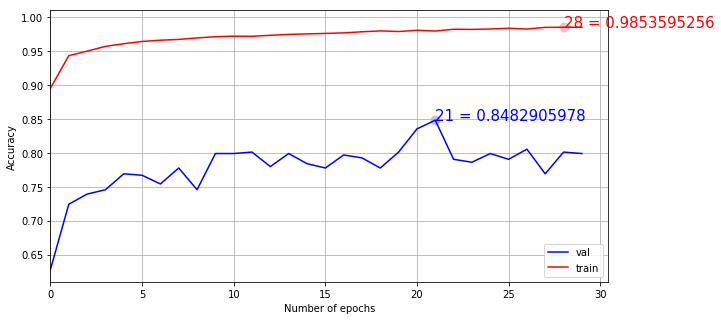

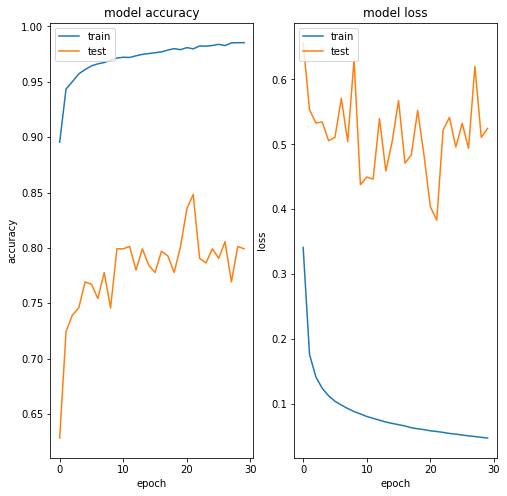

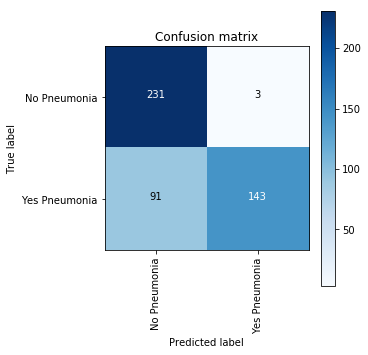

In [13]:
#training network VGG16
pretrainedNetwork(x_train_ros_reshaped, y_train_ros_hot, x_test_ros_reshaped, y_test_ros_hot,
                  pretrained_model_VGG16, pretrained_label_VGG16, dir_transferlearning_vgg16,
                  class_weight_ros, number_classes, max_epoch_vgg16, optimizer, map_characters)

In [14]:
#raining network InceptionV3

#Não obitivemos bons resultados com a InceptionV3

#retrainedNetwork(x_train_ros_reshaped, y_train_ros_hot, x_test_ros_reshaped, y_test_ros_hot,
                  #retrained_model_InceptionV3, pretrained_label_InceptionV3, dir_transferlearning_inception,
                  #lass_weight_ros, number_classes, max_epoch_inception, optimizer, map_characters)